In [86]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/300/'

os.chdir(current_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **ARIMA**

In [87]:
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.arima.model import ARIMA

from datetime import datetime
from funcs_indicator import *



def arima_close(target, use_rows=None):

  size = int(len(target) * 0.66)
  train, test = target[:size].values, target[size:]
  test_shift = test.shift(1).values
  test = test.values
  # break

  history = list(train)
  predictions = list()
  err_ranges = list()
  for t in range(len(test)):
    
      if use_rows is not None:
        history = history[-use_rows:]
        
      model = ARIMA(history, order=(0, 2, 4))
      model_fit = model.fit()
      output = model_fit.forecast()
      # print(output)
      # break

      predictions.append(output[0])
      err_ranges.append(output[1])
      obs = test[t]
      # print('obs :', obs)
      history.append(obs)
      # break
      print('\r %.2f%%' % (t / len(test) * 100), end='')

  print(len(test), len(predictions))

  return predictions, err_ranges


# print(high)


def get_back_result(ohlcv, predictions, err_ranges, indicator, tp=0.04, sl=None, leverage=1, show_detail=False, show_plot=False, return_pr=False, cumsum=False, 
                    close_ver=False, reverse_short=False, show_chart=False):

  
  high, low, close = np.split(ohlcv.values[-len(predictions):, [1, 2, 3]], 3, axis=1)
  indicator = indicator.values

  if close_ver:
    predictions = ohlcv['close'].shift(1).values[-len(close):]

  fee = 0.0006
  long_profits = []
  short_profits = []
  liquidations = []
  win_cnt = 0
  for i in range(len(close)):

    long_ep = predictions[i]
    if sl is not None:
      long_sl = long_ep * (1 / (sl + 1))

    # assert long_ep < long_exit, 'long_exit < long_ep !, %s, %s' % (long_exit, long_ep)
    
    short_ep = (predictions[i] + err_ranges[i]) * (1 + tp)
    # short_ep = (predictions[i] + err_ranges[i]) * (1 / (1 - tp))
    if sl is not None:
      short_sl = short_ep * (1 / (1 - sl))

    # print((low[i]))

    #    long 우선   # <-- long & short 둘다 체결된 상황에서는 long 체결을 우선으로 한다.
    #         tick range 내에 ep 가 포함되어야함      #
    # if low[i] < long_ep:

    #       new constraint    #
    # if indicator[i - 1] < close[i - 1]:   # sar, ema1
    if indicator[i - 2] < 50 and indicator[i - 1] > 50:   # stoch_d
      pass
    else:
      long_profits.append(1.0)
      short_profits.append(1.0)
      liquidations.append(1.0)
      continue

    if low[i] < long_ep < high[i]:
      
      liquidation = low[i] / long_ep - fee
      l_liquidation = 1 + (liquidation - 1) * leverage
      liquidations.append(l_liquidation)

      if max(l_liquidation, 0) == 0:
        l_profit = 0
        # print('low[i], long_ep, l_liquidation :', low[i], long_ep, l_liquidation)
      else:

        if sl is not None:
          if low[i] < long_sl:
            profit = long_sl / long_ep - fee
          else:
            profit = close[i] / long_ep - fee

        else:
          profit = close[i] / long_ep - fee

        l_profit = 1 + (profit - 1) * leverage
        l_profit = max(l_profit, 0)
        
        if profit >= 1:
          win_cnt += 1

      long_profits.append(l_profit)
      short_profits.append(1.0)

      if show_detail:
        print(close[i], predictions[i], long_ep)

      if show_chart:
        if i > 10:
          plt.plot(close[i + 1 - 10: i + 1], label='close')
          # plt.plot(predictions[i + 1 - 10: i + 1], label='ep')
          # plt.plot(high[i + 1 - 10: i + 1], label='high')
          # plt.plot(low[i + 1 - 10: i + 1], label='low')
          plt.plot(indicator[i + 1 - 10: i + 1], label='indicator')
          plt.legend()
          plt.show()

    # if high[i] > short_ep > low[i]: # 지정 대기가 아니라, 해당 price 가 지나면, long 한다.

    #   if not reverse_short:
    #     liquidation = short_ep / high[i]  - fee
    #   else:
    #     liquidation = low[i] / short_ep  - fee
    #   l_liquidation = 1 + (liquidation - 1) * leverage

    #   if max(l_liquidation, 0) == 0:
    #     l_profit = 0
    #   else:

    #     if sl is not None:
    #       if high[i] > short_sl:

    #         if not reverse_short:
    #           profit = short_ep / short_sl - fee
    #         else:
    #           profit = short_sl / short_ep - fee

    #       else:
    #         if not reverse_short:
    #           profit = short_ep / close[i] - fee
    #         else:
    #           profit = close[i] / short_ep - fee

    #     else:

    #       if not reverse_short:
    #         profit = short_ep / close[i] - fee
    #       else:
    #         profit = close[i] / short_ep - fee

    #     l_profit = 1 + (profit - 1) * leverage
    #     l_profit = max(l_profit, 0)

    #     if profit >= 1:
    #       win_cnt += 1

    #   short_profits.append(l_profit)
    #   long_profits.append(1.0)

    #   if show_detail:
    #     print(close[i], predictions[i], short_ep)
    
    else:
      long_profits.append(1.0)
      short_profits.append(1.0)
      liquidations.append(1.0)


  long_win_ratio = sum(np.array(long_profits) > 1.0) / sum(np.array(long_profits) != 1.0)
  short_win_ratio = sum(np.array(short_profits) > 1.0) / sum(np.array(short_profits) != 1.0)
  long_frequency = sum(np.array(long_profits) != 1.0) / len(close)
  short_frequency = sum(np.array(short_profits) != 1.0) / len(close)
  if not cumsum:
    long_accum_profit = np.array(long_profits).cumprod()
    short_accum_profit = np.array(short_profits).cumprod()
  else:
    long_accum_profit = (np.array(long_profits) - 1.0).cumsum()
    short_accum_profit = (np.array(short_profits) - 1.0).cumsum()

  # print(win_ratio)

  if show_plot:

    plt.figure(figsize=(10, 5))
    plt.suptitle('tp=%.4f, lvrg=%d' % (tp, leverage))

    plt.subplot(151)
    plt.plot(liquidations)
    plt.title('liquidations')

    plt.subplot(152)
    plt.plot(long_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (long_win_ratio * 100, long_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(153)
    plt.plot(long_accum_profit)
    plt.title('Accum_profit : %.2f' % long_accum_profit[-1], color='black')

    plt.subplot(154)
    plt.plot(short_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (short_win_ratio * 100, short_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(155)
    plt.plot(short_accum_profit)
    plt.title('Accum_profit : %.2f' % short_accum_profit[-1], color='black')
    plt.show()

  return [long_win_ratio, short_win_ratio], [long_frequency, short_frequency], [long_accum_profit[-1], short_accum_profit[-1]], [long_profits, short_profits]


# get_back_result(tp=0.04, leverage=1, show_plot=True)


In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

interval = '30m'
date_path = './candlestick_concated/%s/2021-04-27/' % interval
file_list = os.listdir(date_path)

print((file_list))

['2021-04-27 BTCUSDT.xlsx', '2021-04-27 ETHUSDT.xlsx', '2021-04-27 BCHUSDT.xlsx', '2021-04-27 XRPUSDT.xlsx', '2021-04-27 EOSUSDT.xlsx', '2021-04-27 LTCUSDT.xlsx', '2021-04-27 ETCUSDT.xlsx', '2021-04-27 LINKUSDT.xlsx', '2021-04-27 XLMUSDT.xlsx', '2021-04-27 ADAUSDT.xlsx', '2021-04-27 XMRUSDT.xlsx', '2021-04-27 SXPUSDT.xlsx', '2021-04-27 KAVAUSDT.xlsx', '2021-04-27 BANDUSDT.xlsx', '2021-04-27 DASHUSDT.xlsx', '2021-04-27 ZECUSDT.xlsx', '2021-04-27 XTZUSDT.xlsx', '2021-04-27 BNBUSDT.xlsx', '2021-04-27 ATOMUSDT.xlsx', '2021-04-27 ONTUSDT.xlsx', '2021-04-27 IOTAUSDT.xlsx', '2021-04-27 BATUSDT.xlsx', '2021-04-27 NEOUSDT.xlsx', '2021-04-27 QTUMUSDT.xlsx', '2021-04-27 WAVESUSDT.xlsx', '2021-04-27 MKRUSDT.xlsx', '2021-04-27 SNXUSDT.xlsx', '2021-04-27 DOTUSDT.xlsx', '2021-04-27 THETAUSDT.xlsx', '2021-04-27 ALGOUSDT.xlsx', '2021-04-27 KNCUSDT.xlsx', '2021-04-27 ZRXUSDT.xlsx', '2021-04-27 COMPUSDT.xlsx', '2021-04-27 OMGUSDT.xlsx']


### **Model**

In [89]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import pickle
from sklearn.model_selection import train_test_split
from datetime import datetime

from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import class_weight

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from funcs_indicator import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

np.random.shuffle(file_list)
candis = file_list

long_index = 0
leverage = 5
prev_x = None
total_x = None

seed = 1
random_state = 201
np.random.seed(seed)

result_df = pd.DataFrame(index=candis)
pairs_pr, pairs_wr = [], []

for i in range(len(candis)):

  keys = [candis[i]]
  
  # if 'algo'.upper() not in candis[i]:
  #   continue


  # if '02-11' not in candis[i]:  # <-- 04-08 includes all timestamp range
  #   continue  

  if 'eth'.upper() not in candis[i]:
    continue



  for key in keys:  

    # print(profit_result_dict[key]['leverage_ap_list'])

    # for tp in [max_peak_tp]:

      # if tp == peak_tp:
      #   plt.subplot(1,10,5)
      # else:
      #   plt.subplot(1,10,6)

      #     leverage analysis     #
      # ohlcv = load_dict[key]['ohlcv']

    # if 'eth'.upper() not in key:
    #   continue
    
    ohlcv = pd.read_excel(date_path + key, index_col=0)
    print('len(ohlcv) :', len(ohlcv))


start_stamp : 0
len(ohlcv) : 18048


In [90]:
def find_trend(data, period:int):
    '''
    Inputs:
    takes in a dataframe and an interger
    Outputs:
    returns True if the trend of the simple moving average over given period is positive, else returns False
    '''
    data['SMA'] = data['close'].rolling(period).mean()
    return (data['SMA']-data['SMA'].shift(1)) > 0

In [91]:
ohlcv['trend'] = find_trend(ohlcv, 3)
ohlcv.trend.head()

2020-04-17 00:29:59.999    False
2020-04-17 00:59:59.999    False
2020-04-17 01:29:59.999    False
2020-04-17 01:59:59.999    False
2020-04-17 02:29:59.999    False
Name: trend, dtype: bool

In [92]:
def find_bullish_harami(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where bullish harami appears
    '''
    # Opened higher than previous close
    condition_1_BH = data['open'] > data['close'].shift(1) 
    # closed lower than prev open
    condition_2_BH = data['close'] < data['open'].shift(1) 
    # previous candle is red
    condition_3_BH = data['open'].shift(1) > data['close'].shift(1) 
    # the candle is green
    condition_4_BH = data['close'] > data['open'] 
    # must appear in a downtrend
    condition_5_BH = ~ data['trend']
    return condition_1_BH & condition_2_BH & condition_3_BH & condition_4_BH & condition_5_BH

In [93]:
ohlcv['Bullish_Harami'] = find_bullish_harami(ohlcv)

In [94]:
ohlcv['Bullish_Harami'].value_counts()

False    17517
True       531
Name: Bullish_Harami, dtype: int64

In [95]:
100 * ohlcv['Bullish_Harami'].sum()/ohlcv.shape[0]

2.942154255319149

Looks like we have 220 Bullish Haramis in our dataset. Namely, 2.27% of all the candlesticks.
The number makes sense, since candlestick patterns don't appear too often. Let's look for bearish haramis now:

Conditions of a bearish harami are similar to those of bullish harami, only the trend has been reversed:
- The big candle apprears first and is green
- The smaller candle appears next and is red 


In [96]:
def find_bearish_harami(data):
    '''
    
    Takes in a dataframe containing closing prices of the stock and returns True where bearish harami appears
    '''
    Bear_Har_cond_1 = data['close'].shift(1) > data['open']
    Bear_Har_cond_2 = data['close'] > data['open'].shift(1)
    Bear_Har_cond_3 = data['close'].shift(1) > data['open'].shift(1)
    Bear_Har_cond_4 = data['open'] > data['close'] 
    Bear_Har_cond_5 = data['trend']
    
    return Bear_Har_cond_1 & Bear_Har_cond_2 & Bear_Har_cond_3 & Bear_Har_cond_4 & Bear_Har_cond_5

In [97]:
ohlcv['Bearish_Harami'] = find_bearish_harami(ohlcv)

In [98]:
ohlcv['Bearish_Harami'].value_counts()

False    17512
True       536
Name: Bearish_Harami, dtype: int64

In [99]:
100 * ohlcv['Bearish_Harami'].sum()/ohlcv.shape[0]

2.969858156028369

a total of 170 bearish haramis have appeared in the dataset. Namely, 1.75% of the candlesticks are bearish harami

Next candlestick pattern is the bullish engulfing pattern. A bullish engulfing pattern occurs after a price move lower and indicates higher prices to come. The first candle, in the two-candle pattern, is a down candle. The second candle is a larger up candle, with a real body that fully engulfs the smaller down candle. 

In [100]:
def find_bullish_engulfing(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where bullish engulfing appears
    '''
    # the second candle must close higher than previous candle
    Bull_Eng_cond_1 = data['close'] > data['open'].shift(1)
    # the second candle must open lower than previous canlde
    Bull_Eng_cond_2 = data['close'].shift(1) > data['open']
    # The second canlde must be green
    Bull_Eng_cond_3 = data['close'] > data['open']
    # The first candle must be red
    Bull_Eng_cond_4 = data['open'].shift(1) > data['close'].shift(1)
    
    Bull_Eng_cond_5 = ~ data['trend']
    
    return Bull_Eng_cond_1 & Bull_Eng_cond_2 & Bull_Eng_cond_3  & Bull_Eng_cond_4 & Bull_Eng_cond_5

In [101]:
ohlcv['Bullish_Engulfing'] = find_bullish_engulfing(ohlcv)

In [102]:
ohlcv['Bullish_Engulfing'].value_counts()

False    17855
True       193
Name: Bullish_Engulfing, dtype: int64

In [103]:
100 * ohlcv['Bullish_Engulfing'].sum() / ohlcv.shape[0]

1.0693705673758864

Next we will look at bearish engulfing pattern, the idea is the same as bullish engulfing, but the colors are reversed.

In [104]:
def find_bearish_engulfing(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where bearish engulfing appears
    '''
    Bear_Eng_cond_1 = data['open'] > data['close'].shift(1)
    Bear_Eng_cond_2 = data['open'].shift(1) > data['close']
    Bear_Eng_cond_3 = data['close'].shift(1) > data['open'].shift(1)
    Bear_Eng_cond_4 = data['open'] > data['close']
    Bear_Eng_cond_5 = data['trend']
    return Bear_Eng_cond_1 & Bear_Eng_cond_2 & Bear_Eng_cond_3 & Bear_Eng_cond_4 & Bear_Eng_cond_5

In [105]:
ohlcv['Bearish_Engulfing'] = find_bearish_engulfing(ohlcv)

In [106]:
ohlcv['Bearish_Engulfing'].value_counts()

False    17818
True       230
Name: Bearish_Engulfing, dtype: int64

In [107]:
100*ohlcv['Bearish_Engulfing'].sum()/ohlcv.shape[0]

1.2743794326241136

Next up: Hammer: A hammer is a type of bullish reversal candlestick pattern, made up of just one candle, found in price charts of financial assets. The candle looks like a hammer, as it has a long lower wick and a short body at the top of the candlestick with little or no upper wick

In [108]:
def find_green_hammer(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where green hammer appears
    '''
    # lower shadow at least twice as long as body
    Gr_Ham_cond_1 = (data['open'] - data['low']) > 2*(data['close']-data['open']) 
    # Upper shadow shorter than a tenth of the body
    Gr_Ham_cond_2 = (data['close']-data['open']) > 10*(data['high'] - data['close'])
    # candle should be green
    Gr_Ham_cond_3 = data['close']>data['open']
    # downtrend
    Gr_Ham_cond_4 = ~ data['trend']
    return Gr_Ham_cond_1 & Gr_Ham_cond_2 & Gr_Ham_cond_3 & Gr_Ham_cond_4

In [109]:
ohlcv['Green_Hammer'] = find_green_hammer(ohlcv)

In [110]:
ohlcv['Green_Hammer'].value_counts()

False    18022
True        26
Name: Green_Hammer, dtype: int64

In [111]:
100*ohlcv['Green_Hammer'].sum()/ohlcv.shape[0]

0.14406028368794327

Usually in the candlestick pattern analysis, the color of the hammer is not important. But let's separate them in our study to see if the green hammer has a more bullish reversal power compred to the red one. We will do the color separation for inverted hammer, shooting star and hanging man as well.

In [112]:
def find_red_hammer(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where red hammer appears'''
    # The wick should be at least twice as long as the body
    Rd_Ham_cond_1 = (data['close'] - data['low']) > 2*(data['open']-data['close'])
    # The lower shadow must be very small, at least 10 times smaller than the body
    Rd_Ham_cond_2 = (data['open']-data['close']) > 10*(data['high'] - data['open']) 
    # candle should be bearish
    Rd_Ham_cond_3 = data['open'] > data['close']
    
    Rd_Ham_cond_4 = ~ data['trend']
    return Rd_Ham_cond_1 & Rd_Ham_cond_2 & Rd_Ham_cond_3 & Rd_Ham_cond_4

In [113]:
ohlcv['Red_Hammer'] = find_red_hammer(ohlcv)

In [114]:
ohlcv['Red_Hammer'].value_counts()

False    17937
True       111
Name: Red_Hammer, dtype: int64

In [115]:
100*ohlcv['Red_Hammer'].sum()/ohlcv.shape[0]

0.6150265957446809

A hanging man is a type of bearish reversal pattern, made up of just one candle, found in an uptrend of price charts of financial assets. It has a long lower wick and a short body at the top of the candlestick with little or no upper wick.


In [116]:
def find_green_hanging(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where hanging man appears'''
    # lower shadow should be at least twice as long as the body
    Gr_Hang_cond_1 = (data['open']-data['low']) > 2*(data['close']-data['open'])
    # Upper shadow shorter than a tenth of the body
    Gr_Hang_cond_2 = (data['close']-data['open']) > 10*(data['high'] - data['close'])
    # candle should be green
    Gr_Hang_cond_3 = data['close'] > data['open']
    Gr_Hang_cond_4 = data['trend']
    return Gr_Hang_cond_1 & Gr_Hang_cond_2 & Gr_Hang_cond_3 & Gr_Hang_cond_4

In [117]:
ohlcv['Green_Hanging'] = find_green_hanging(ohlcv)

In [118]:
ohlcv['Green_Hanging'].value_counts()

False    18020
True        28
Name: Green_Hanging, dtype: int64

In [119]:
100*ohlcv['Green_Hanging'].sum()/ohlcv.shape[0]

0.1551418439716312

We'll separate the green from red to see their difference in predicting a bearish reversal

In [120]:
def find_red_hanging(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where hanging man appears'''
    Rd_Hang_cond_1 = (data['close'] - data['low']) > 2*(data['open']-data['close'])
    Rd_Hang_cond_2 = (data['open']-data['close']) > 10*(data['high'] - data['open'])
    Rd_Hang_cond_3 = data['open'] > data['close']
    Rd_Hang_cond_4 = data['trend']
    return Rd_Hang_cond_1 & Rd_Hang_cond_2 & Rd_Hang_cond_3 & Rd_Hang_cond_4

In [121]:
ohlcv['Red_Hanging'] = find_red_hanging(ohlcv)

In [122]:
ohlcv['Red_Hanging'].value_counts()

False    18014
True        34
Name: Red_Hanging, dtype: int64

In [123]:
ohlcv['Red_Hanging'].sum()/ohlcv.shape[0] *100

0.18838652482269502

A piercing pattern is one of a few important candlestick patterns that technical analysts typically spot on a price series chart. This pattern is formed by two consecutive candlestick marks. The first candlestick is red/black signifying a down day and the second is white/green signifying an up day. When a trader is watching for a bullish reversal any red candlestick followed by a white candlestick could be an alert.

In [124]:
def find_piercing_pattern(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where piercing pattern appears'''
    # Last candle RED
    PP_cond_1 = data['open'].shift(1) > data['close'].shift(1) 
    # This candle GREEN
    PP_cond_2 = data['close'] > data['open'] 
    PP_cond_3 = data['close'].shift(1) > data['open']
    PP_cond_4 = data['close'] > ((data['close'].shift(1) + data['open'].shift(1))/2)
    # NOT ENGULFING 
    PP_cond_5 = data['open'].shift(1) > data['close'] 
    PP_cond_6 = ~data['trend']
    return PP_cond_1 & PP_cond_2 & PP_cond_3 & PP_cond_4 & PP_cond_5 & PP_cond_6

In [125]:
ohlcv['Piercing_Pattern'] = find_piercing_pattern(ohlcv)

In [126]:
ohlcv['Piercing_Pattern'].value_counts()

False    17833
True       215
Name: Piercing_Pattern, dtype: int64

In [127]:
ohlcv['Piercing_Pattern'].sum()/ohlcv.shape[0]*100

1.191267730496454

Dark Cloud Cover is a bearish reversal candlestick pattern where a down candle (typically black or red) opens above the close of the prior up candle (typically white or green), and then closes below the midpoint of the up candle. 

In [128]:
def find_dark_cloud(data):
    '''
    
    Takes in a dataframe containing closing prices of the stock and returns True where dark cloud appears'''
    # Last candle GREEN
    DK_cond_1 = data['close'].shift(1) > data['open'].shift(1) 
    # This candle RED
    DK_cond_2 = data['open'] > data['close'] 
    DK_cond_3 = data['open'] > data['close'].shift(1)
    DK_cond_4 =(data['close'].shift(1) + data['open'].shift(1))/2 > data['close']
    # NOT ENGULFING
    DK_cond_5 = data['close'] > data['open'].shift(1) 
    DK_cond_6 = data['trend']
    return DK_cond_1 & DK_cond_2 & DK_cond_3 & DK_cond_4 & DK_cond_5 & DK_cond_6

In [129]:
ohlcv['Dark_Cloud'] = find_dark_cloud(ohlcv)

In [130]:
ohlcv['Dark_Cloud'].value_counts()

False    17833
True       215
Name: Dark_Cloud, dtype: int64

In [131]:
ohlcv['Dark_Cloud'].sum()/ohlcv.shape[0]*100

1.191267730496454

The Morning Star is a pattern seen in a candlestick chart, a type of chart used by stock analysts to describe and predict price movements of a security, derivative, or currency over time

In [132]:
def find_morning_star(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where morning star appears'''
    # First candle RED
    MS_cond_1 = data['open'].shift(2) > data['close'].shift(2) 
    # Third candle Green
    MS_cond_2 = data['close'] > data['open']
    # Third candle closes higher than the middle one
    MS_cond_3 = (data['close'] > data['close'].shift(1)) 
    
    MS_cond_4 = data['close'] > (data['open']+data['close'])/2
    MS_cond_5 = data['close'].shift(1) < data['open']
    MS_cond_6 = data['open'].shift(1) < data['open']
    MS_cond_7 = (data['close'].shift(1) < data['close'].shift(2)) & (data['open'].shift(1) < data['close'].shift(2))
    MS_cond_8 = ~ data['trend']
    return MS_cond_1 & MS_cond_2 & MS_cond_3 & MS_cond_4 & MS_cond_5 & MS_cond_6 & MS_cond_7 & MS_cond_8
    

In [133]:
ohlcv['Morning_Star'] = find_morning_star(ohlcv)

In [134]:
ohlcv['Morning_Star'].value_counts()

False    18048
Name: Morning_Star, dtype: int64

In [135]:
ohlcv['Morning_Star'].sum()/ohlcv.shape[0]*100

0.0

An evening star is a bearish candlestick pattern consisting of three candles: a large white candlestick, a small-bodied candle, and a red candle.

In [136]:
def find_evening_star(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where evening star appears'''
    # First candle GREEN
    ES_cond_1 = data['close'].shift(2) > data['open'].shift(2)
    ES_cond_2 = data['open'] > data['close'] #nexy candle RED
    ES_cond_3 = data['close'] < (data['close'].shift(2) + data['open'].shift(2))/2
    ES_cond_4 = data['open'].shift(1) > data['close'].shift(2)
    ES_cond_5 = data['close'].shift(1) > data['close'].shift(2)
    ES_cond_6 = data['open'].shift(1) > data['open']
    ES_cond_7 = data['close'].shift(1) > data['open'] 
    ES_cond_8 = data['trend']
    return ES_cond_1 & ES_cond_2 & ES_cond_3 & ES_cond_4 & ES_cond_5 & ES_cond_6 & ES_cond_7 & ES_cond_8

In [137]:
ohlcv['Evening_Star'] = find_evening_star(ohlcv)

In [138]:
ohlcv['Evening_Star'].value_counts()

False    18048
Name: Evening_Star, dtype: int64

In [139]:
ohlcv['Evening_Star'].sum()/ohlcv.shape[0]*100

0.0

A kicker pattern is a two-bar candlestick pattern that is used to predict a change in the direction of the trend for an asset's price. This pattern is characterized by a very sharp reversal in price over the span of two candlesticks; traders use it to determine which group of market participants is in control of the direction. The pattern points to a strong change in investors' attitude surrounding a security. This usually occurs following the release of valuable information about a company, industry or an economy.

In [140]:
def find_bull_kicker(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where bull kicker appears'''
    # the two candles open at the same level (within a small tolerance)
    BK_cond_1 = abs(data['open'].shift(1) - data['open']) < 0.002 * data['open']
    BK_cond_2 = data['open'].shift(1) > data['close'].shift(1) # last candle red
    BK_cond_3 = data['close'] > data['open'] #candle GREEN
    BK_cond_4 = data['low'] > data['open'].shift(1)
    return BK_cond_1 & BK_cond_2 & BK_cond_3 & BK_cond_4

In [141]:
ohlcv['Bull_Kicker'] = find_bull_kicker(ohlcv)
ohlcv['Bull_Kicker'].value_counts()

False    18048
Name: Bull_Kicker, dtype: int64

In [142]:
ohlcv['Bull_Kicker'].sum()/ohlcv.shape[0]*100

0.0

In [143]:
def find_bear_kicker(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where bear kicker appears'''
    # the two candles open at the same level (within a small tolerance)
    BRK_cond_1 = abs(data['open'].shift(1) - data['open']) < 0.002 * data['open']
    # last candle GREEN
    BRK_cond_2 = data['close'].shift(1) > data['open'].shift(1)
    # this candle RED
    BRK_cond_3 = data['open'] > data['close'] 
    BRK_cond_4 = data['open'].shift(1) > data['high']
    return BRK_cond_1 & BRK_cond_2 & BRK_cond_3 & BRK_cond_4

In [144]:
ohlcv['Bear_Kicker'] = find_bear_kicker(ohlcv)
ohlcv['Bear_Kicker'].value_counts()

False    18048
Name: Bear_Kicker, dtype: int64

In [145]:
ohlcv['Bear_Kicker'].sum()/ohlcv.shape[0]*100

0.0

In technical analysis, a shooting star is interpreted as a type of reversal pattern presaging a falling price. The Shooting Star looks exactly the same as the Inverted hammer, but instead of being found in a downtrend it is found in an uptrend and thus has different implications.

In [146]:
def find_green_shooting_star(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where shooting star appears'''
    SHS_1 =(data['high'] - data['close']) > 2 * (data['close'] - data['open'])
    SHS_2 =(data['close'] - data['open']) > 10*(data['open'] - data['low'])
    SHS_3 = data['close'] > data['open']
    SHS_4 = data['trend'] 
    return SHS_1 & SHS_2 & SHS_3 & SHS_4

In [147]:
ohlcv['Green_Shooting_Star'] = find_green_shooting_star(ohlcv)
ohlcv['Green_Shooting_Star'].value_counts()

False    17960
True        88
Name: Green_Shooting_Star, dtype: int64

In [148]:
ohlcv['Green_Shooting_Star'].sum()/ohlcv.shape[0]*100

0.4875886524822695

Let's separate red and green to see their difference in predicting a reversal

In [149]:
def find_red_shooting_star(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where shooting star appears'''
    RSH_1 =(data['high'] - data['open']) > 2 * (data['open'] - data['close'])
    RSH_2 =(data['open'] - data['close']) > 10*(data['close'] - data['low'])
    RSH_3 = data['open'] > data['close'] #is Red
    RSH_4 = data['trend']
    return RSH_1 & RSH_2 & RSH_3 & RSH_4

In [150]:
ohlcv['Red_Shooting_Star'] = find_red_shooting_star(ohlcv)
ohlcv['Red_Shooting_Star'].value_counts()

False    18034
True        14
Name: Red_Shooting_Star, dtype: int64

In [151]:
ohlcv['Red_Shooting_Star'].sum()/ohlcv.shape[0]*100

0.07757092198581561

he inverted hammer is a type of candlestick pattern found after a downtrend and is usually taken to be a trend-reversal signal. The inverted hammer looks like an upside down version of the hammer candlestick pattern, and when it appears in an uptrend is called a shooting star. 

In [152]:
def find_green_inverted_hammer(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where inverted hammer appears'''
    GIH_1 =(data['close']-data['open']) > 10*(data['open']-data['low']) 
    GIH_2 =(data['high']-data['close']) > 2*(data['close']-data['open'])
    GIH_3 = data['close']>data['open']
    GIH_4 = ~data['trend']
    return GIH_1 & GIH_2 & GIH_3 & GIH_4

In [153]:
ohlcv['Green_Inverted_Hammer'] = find_green_inverted_hammer(ohlcv)
ohlcv['Green_Inverted_Hammer'].value_counts()

False    18014
True        34
Name: Green_Inverted_Hammer, dtype: int64

In [154]:
ohlcv['Green_Inverted_Hammer'].sum()/ohlcv.shape[0]*100

0.18838652482269502

In [155]:
def find_red_inverted_hammer(data):
    '''
    Takes in a dataframe containing closing prices of the stock and returns True where inverted hammer appears'''
    RIH_1 =(data['open']-data['close']) > 10*(data['close']-data['low']) 
    RIH_2 =(data['high']-data['open']) > 2*(data['open']-data['close'])
    RIH_3 = data['open']>data['close'] #is red
    RIH_3 = ~data['trend']
    return RIH_1 & RIH_2 & RIH_3

In [156]:
ohlcv['Red_Inverted_Hammer'] = find_red_inverted_hammer(ohlcv)
ohlcv['Red_Inverted_Hammer'].value_counts()

False    18019
True        29
Name: Red_Inverted_Hammer, dtype: int64

In [157]:
ohlcv['Red_Inverted_Hammer'].sum()/ohlcv.shape[0]*100

0.16068262411347517

Now that we have identified where our candlestick patterns of interest appear, let's crunch some numbers together



In [158]:
candlesticks_count = ohlcv.drop(['open','close','high','low','volume','SMA','trend'],axis=1).sum()

In [159]:
candlesticks_count

Bullish_Harami           531
Bearish_Harami           536
Bullish_Engulfing        193
Bearish_Engulfing        230
Green_Hammer              26
Red_Hammer               111
Green_Hanging             28
Red_Hanging               34
Piercing_Pattern         215
Dark_Cloud               215
Morning_Star               0
Evening_Star               0
Bull_Kicker                0
Bear_Kicker                0
Green_Shooting_Star       88
Red_Shooting_Star         14
Green_Inverted_Hammer     34
Red_Inverted_Hammer       29
dtype: int64

Text(0.5, 1.0, 'Frequency of Patterns in Apple Stock')

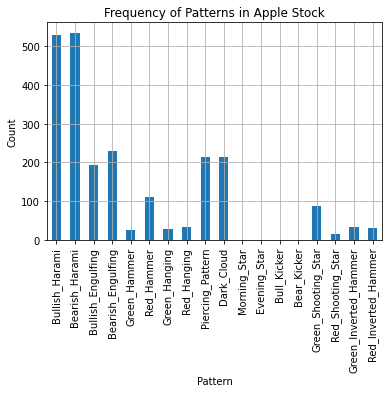

In [160]:
%matplotlib inline
ax = candlesticks_count.plot.bar()
ax.grid()
ax.set_xlabel('Pattern')
ax.set_ylabel('Count')
ax.set_title('Frequency of Patterns in Apple Stock')

This shows how some candlestick patterns can appear frequently but others are quite rare to find!

In [161]:
ohlcv.drop(['open','close','high','low','volume','SMA','trend'],axis=1).sum().sum()

2284

A total of 994 candlestick patterns have occured.

##### Prediction score:
let's define the prediction score to be the fraction of the times that the pattern correctly predicted a price change to the total number of times the pattern appeared. 

In [162]:
def get_prediction_score(data, candlestick_pattern: str):
    '''
    takes in a dataframe and the name of a candlestick pattern and calculates the fraction of times the candlestick patter
    managed to predict the market correctly
    '''
    initial_prices = data['close'][data[candlestick_pattern]==1]
    next_price_point = data['close'][data[candlestick_pattern].shift(1)==1]
    price_increased = next_price_point.reset_index(drop=True) > initial_prices.reset_index(drop=True)
    price_dropped = next_price_point.reset_index(drop=True) < initial_prices.reset_index(drop=True)
    if candlestick_pattern in ['Bullish_Harami', 'Bullish_Engulfing', 'Green_Hammer', 'Red_Hammer', 'Piercing_Pattern',
                               'Morning_Star', 'Bull_Kicker', 'Green_Inverted_Hammer', 'Red_Inverted_Hammer']:
        prediction_score = price_increased.sum()/len(price_increased)
        return prediction_score
    # elif used rather than else to prevent typos to misclassify bullish and bearish signals
    elif candlestick_pattern in ['Bearish_Harami', 'Bearish_Engulfing', 'Green_Hanging', 'Red_Hanging', 'Dark_Cloud',
                                 'Evening_Star', 'Bear_Kicker', 'Green_Shooting_Star', 'Red_Shooting_Star']:
        prediction_score = price_dropped.sum()/len(price_dropped)
        return prediction_score
    else:
        print(f'Sorry, {candlestick_pattern} was not found in our list of modeled candlestick pattern ')
        

In [163]:
scores = pd.Series()
candlesticks = ['Bullish_Harami', 'Bearish_Harami','Bullish_Engulfing', 'Bearish_Engulfing','Green_Hammer', 'Red_Hammer',
                    'Green_Hanging', 'Red_Hanging','Piercing_Pattern', 'Dark_Cloud', 'Morning_Star','Evening_Star',
                    'Bull_Kicker', 'Bear_Kicker', 'Green_Shooting_Star', 'Red_Shooting_Star',
                    'Green_Inverted_Hammer', 'Red_Inverted_Hammer' ]
for pattern in candlesticks:
    scores[pattern] = get_prediction_score(ohlcv, pattern)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


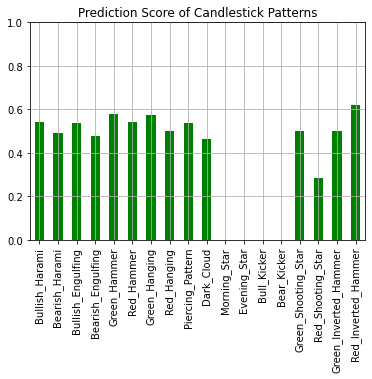

In [164]:
ax = scores.plot.bar(color='green')
ax.set_title('Prediction Score of Candlestick Patterns')
ax.set_ylim(0,1)
ax.grid()

### Check shuffled index

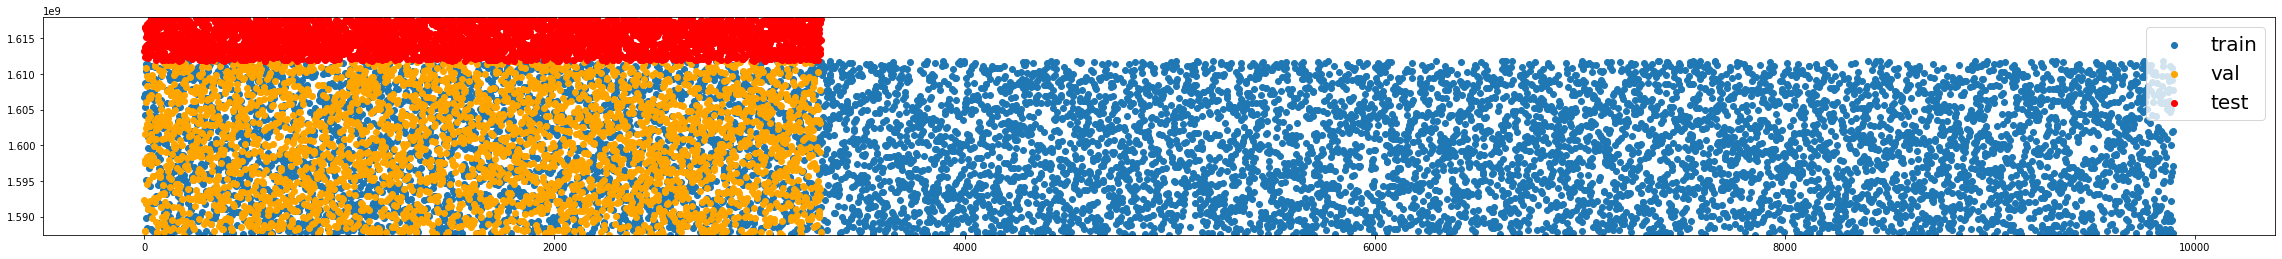

In [ ]:
# print(index_val)
from datetime import datetime

# print(index_test)
# print(index_train)
# print(index_val)
total_stamp = list(map(lambda x: datetime.timestamp(x[0]), input_index)) 
timestamp_train = list(map(lambda x: datetime.timestamp(x[0]), index_train)) 
timestamp_val = list(map(lambda x: datetime.timestamp(x[0]), index_val)) 
timestamp_test = list(map(lambda x: datetime.timestamp(x[0]), index_test)) 
# print(total_stamp)
# print(timestamp_train)
plt.figure(figsize=(40, 4))
plt.scatter(range(len(timestamp_train)), timestamp_train, label='train')
plt.scatter(range(len(timestamp_val)), timestamp_val, color='orange', label='val')
plt.scatter(range(len(timestamp_test)), timestamp_test, color='red', label='test')
plt.ylim(min(total_stamp), max(total_stamp))
plt.legend(fontsize=20)

# print(new_input_index)

### Load Data

In [ ]:
period = 45

x_save_path = current_path + 'npy/' + '%s_rnn_close_updown_x_train_neo_timesplit.npy' % period
x_train = np.load(x_save_path)
x_val = np.load(x_save_path.replace('x_train', 'x_val'))
x_test = np.load(x_save_path.replace('x_train', 'x_test'))
print('x series loaded !')

pr_save_path = current_path + 'npy/' + '%s_rnn_close_updown_pr_train_neo_timesplit.npy' % period
pr_train = np.load(pr_save_path)
pr_val = np.load(pr_save_path.replace('pr_train', 'pr_val'))
pr_test = np.load(pr_save_path.replace('pr_train', 'pr_test'))
print('y series loaded !')

_, row, col = x_train.shape



x series loaded !
y series loaded !


In [ ]:
print(keras.__version__)
print(tf.__version__)

2.3.1
1.15.2


### **Data Split**

### **Training**

In [ ]:
org_x_test = x_test
org_y_test = y_test
org_pr_test = pr_test

In [ ]:
x_test = org_x_test
y_test = org_y_test
pr_test = org_pr_test

In [ ]:
concat_x = np.vstack((org_x_test, new_input_x))
concat_y = np.vstack((org_y_test, np.where(new_input_pr > 1, 1, 0)))
concat_pr = np.vstack((org_pr_test, new_input_pr))

In [ ]:
x_test = new_input_x
y_test = np.where(new_input_pr > 1, 1, 0)
pr_test = new_input_pr

In [ ]:
# print(pred_pr_list)
for pr in pred_pr_list:
  if pr != 1:
    print(pr)

In [ ]:
plt.figure(figsize=(50, 5))
plt.plot(np.cumprod(pred_pr_list)[len(org_pr_test):len(org_pr_test) + 10])
# plt.plot(np.cumprod(pred_pr_list)[len(org_pr_test) - 10:len(org_pr_test) + 10])
plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
# plt.axvline(len(org_pr_test), linestyle='--', color='r')
plt.show()

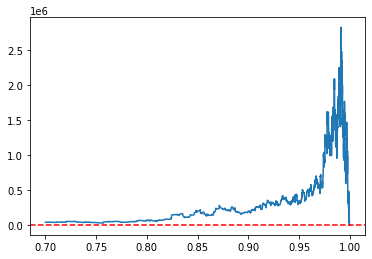

In [ ]:
# plt.show()
# plt.subplot(122)
plt.plot(new_thresh, acc_pr_bythr)
plt.axhline(np.cumprod(test_pr_list)[-1], linestyle='--', color='r')
plt.show()

#### **clustering output**

In [ ]:
# x_train_for_k = test_result.flatten().reshape(-1, 1)
x_train_for_k = test_result
print(x_train_for_k[:10])
# x_train_for_k = test_result[:, [1]]
pr_train = pr_test

print('x_train_for_k.shape :', x_train_for_k.shape)
print('pr_train.shape :', pr_train.shape)

K = range(2, 10)
s_dist = []
sil = []
for k in K:
  # if cen_data.shape[0] < k:
  #   break

  km = KMeans(n_clusters=k)
  km = km.fit(x_train_for_k)

  labels = km.labels_
  # print('len(labels) :', len(labels))
  # print('labels[:10] :', labels[:10])
  sil.append(silhouette_score(x_train_for_k, labels, metric='euclidean'))

  # inertia = km.inertia_
  # s_dist.append(inertia)

best_k = K[np.argmax(np.array(sil))]

plt.figure(figsize=(10, 5))
plt.plot(K, sil)
plt.axvline(best_k, linestyle='--')
# plt.plot(K, s_dist)
plt.show()





#   with best_k, label 별 pr_list 확인
km = KMeans(n_clusters=best_k)
km = km.fit(x_train_for_k)

labels = km.labels_

print(km.score(x_train_for_k))
print(len(labels), len(pr_train))





#   label 별로 profit 을 저장, 승률을 확인한다
label_types = np.unique(labels, return_counts=False)

label_pr_dict = {}
#   init dict   #
for label in label_types:
  label_pr_dict[label] = []
print(label_pr_dict)
# break

for i, (label, pr) in enumerate(zip(labels, pr_train)):
  label_pr_dict[label].append(pr[0])

  
# for label in label_types:
print(label_pr_dict)





def win_ratio(list_x):

  win_cnt = np.sum(np.array(list_x) > 1)
  return win_cnt / len(list_x)


def acc_pr(list_x):

  return np.cumprod(np.array(list_x))[-1]


for key in label_pr_dict:
  
  print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))





#     predict test && test 의 라벨에 따른 win_ratio 확인
# test_labels = km.predict(x_test)
# # print(test_labels)

# label_pr_dict = {}
# #   init dict   #
# for label in label_types:
#   label_pr_dict[label] = []
# print(label_pr_dict)
# # break

# for i, (label, pr) in enumerate(zip(test_labels, pr_test)):
#   label_pr_dict[label].append(pr[0])

# for key in label_pr_dict:

#   print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))

